## Final Project for CM3070

This is an exploratory notebook into the dataset `TruthSeeker2023`. Our first step involves importing the necessary libraries to facilitate our analysis and insights extraction process.

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import textstat
from textblob import TextBlob
import statsmodels.formula.api as smf

Load the dataset into a pandas Dataframe and inspect it

In [3]:
# Set the path to the dataset
dataset_path = '../../datasets/TruthSeeker2023/Truth_Seeker_Model_Dataset.csv'

# Load the dataset into a pandas dataframe, ensuring the header is inferred from the first row
df = pd.read_csv(dataset_path, header=0)

# Display the first five rows of the dataframe to inspect it
df.head(5)

,Unnamed: 0,author,statement,target,BinaryNumTarget,manual_keywords,tweet,5_label_majority_answer,3_label_majority_answer
0,0,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders - 6 Month Update\n\nInfl...,Mostly Agree,Agree
1,1,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,NO MAJORITY,Agree
2,2,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",THE SUPREME COURT is siding with super rich pr...,Agree,Agree
3,3,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders\n\nBroken campaign promi...,Mostly Agree,Agree
4,4,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@OhComfy I agree. The confluence of events rig...,Agree,Agree


Counting columns, target values

In [4]:
# Display the number of columns in the dataframe
print(f"Number of columns in the dataframe: {len(df.columns)}")

# Show a count of different values available in the 'target' column
print("Count of different values in 'target' column:")
print(df['target'].value_counts())

# Show a count of different values available in the next column
print(f"Count of different values in 'BinaryNumTarget' column:")
print(df['BinaryNumTarget'].value_counts())

print(df['target'].dtype)



Number of columns in the dataframe: 9
Count of different values in 'target' column:
target
True     68930
False    65268
Name: count, dtype: int64
Count of different values in 'BinaryNumTarget' column:
BinaryNumTarget
1.0    68930
0.0    65268
Name: count, dtype: int64
bool


It seems to be a balanced dataset! That is promising.

## Data Preprocessing

In this section, we perform some data preprocessing on our dataframe `df`. The dataframe contains several columns, among which `target`, `5_label_majority_answer`, and `3_label_majority_answer` are of our interest.

The `target` column contains boolean values (True/False), `5_label_majority_answer` can have five different values: 'agree', 'mostly agree', 'disagree', 'mostly disagree' and 'NO MAJORITY', and `3_label_majority_answer` can have three different values: 'agree', 'disagree' and 'unrelated'.

We first filter out the rows where `5_label_majority_answer` is 'NO MAJORITY' or `3_label_majority_answer` is 'unrelated'. This is done to focus our analysis on the rows where we have a clear majority answer.

Next, we create a new column `categorical_label` based on the values in `target` and `3_label_majority_answer` columns. The value in `categorical_label` is True if `target` is True and `3_label_majority_answer` is 'agree', or if `target` is False and `3_label_majority_answer` is 'disagree'. Otherwise, the value in `categorical_label` is False.

Finally, we create another column `BinaryNumLabel` which is a numerical representation of `categorical_label`. The value in `BinaryNumLabel` is 1.0 if `categorical_label` is True, and 0.0 if `categorical_label` is False. This will be useful for any machine learning algorithms that require numerical input.

In [5]:
# First, eliminate from the dataframe every row that has in the corresponding column the value of NO MAJORITY, or the value of unrelated.
df = df[(df['5_label_majority_answer'] != 'NO MAJORITY') & (df['3_label_majority_answer'] != 'unrelated')]

# Function to calculate categorical_label
def calculate_categorical_label(row):
    label = row['3_label_majority_answer'].lower()  # convert to lowercase
    if row['target'] == True and label == 'agree':
        return True
    elif row['target'] == True and label == 'disagree':
        return False
    elif row['target'] == False and label == 'agree':
        return False
    elif row['target'] == False and label == 'disagree':
        return True

# Apply the function to the dataframe
df['categorical_label'] = df.apply(calculate_categorical_label, axis=1)

# Create BinaryNumLabel column
df['BinaryNumLabel'] = df['categorical_label'].apply(lambda x: 1.0 if x == True else 0.0)

df.head(5)

,Unnamed: 0,author,statement,target,BinaryNumTarget,manual_keywords,tweet,5_label_majority_answer,3_label_majority_answer,categorical_label,BinaryNumLabel
0,0,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders - 6 Month Update\n\nInfl...,Mostly Agree,Agree,True,1.0
2,2,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",THE SUPREME COURT is siding with super rich pr...,Agree,Agree,True,1.0
3,3,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders\n\nBroken campaign promi...,Mostly Agree,Agree,True,1.0
4,4,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@OhComfy I agree. The confluence of events rig...,Agree,Agree,True,1.0
5,5,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium","I've said this before, but it really is incred...",Agree,Agree,True,1.0


Quick check of the remainder rows and whether is still a balanced dataset

In [6]:
# Show a count of different values available in the 'target' column
print("Count of different values in 'categorical_label' column:")
print(df['categorical_label'].value_counts())

# Show a count of different values available in the next column
print(f"Count of different values in 'BinaryNumLabel' column:")
print(df['BinaryNumLabel'].value_counts())

Count of different values in 'categorical_label' column:
categorical_label
True     57429
False    54164
Name: count, dtype: int64
Count of different values in 'BinaryNumLabel' column:
BinaryNumLabel
1.0    57429
0.0    54164
Name: count, dtype: int64


Preprocessing of Tweets
Preprocessing is a crucial step in any Natural Language Processing (NLP) task, including text classification of tweets. The goal of preprocessing is to clean and standardize the data before it is input into a model. Here are the preprocessing steps we used:

Lowercasing: We convert all the text to lowercase. This helps to avoid having multiple copies of the same words (e.g., ‘Hello’, ‘hello’, ‘HELLO’).
Handling URLs: We remove URLs as they may not provide useful information for our task. URLs are identified using regular expressions and are removed from the tweets.
Handling User Mentions: User mentions (i.e., strings starting with ‘@’) are removed as they might not provide useful information for our task.
Handling Hashtags: Hashtags (i.e., strings starting with ‘#’) can be tricky. They often convey important information in tweets. We keep the text of the hashtag but remove the ‘#’ symbol.

In [6]:
import re


# Preprocessing
def preprocess_tweet(text):
    text = text.lower()  # convert to lowercase
    text = re.sub(r"http\\S+|www\\S+|https\\S+", '', text, flags=re.MULTILINE)  # remove urls
    text = re.sub(r'\\@\\w+|\\#','', text)  # remove mentions and hashtags
    return text

df['processed_tweet'] = df['tweet'].apply(preprocess_tweet)

Use of Classical ML Classifiers
We use several classical machine learning classifiers to perform the task of text classification on our preprocessed tweets. These classifiers include:

Random Forest: This is an ensemble learning method that operates by constructing multiple decision trees at training time and outputting the class that is the mode of the classes of the individual trees.
Naive Bayes: This is a probabilistic classifier based on applying Bayes’ theorem with strong independence assumptions between the features.
Logistic Regression: Despite its name, this is a linear model for classification rather than regression. It is also known as logit regression, maximum-entropy classification (MaxEnt), or the log-linear classifier.
Gradient Boosting Classifier: This is another ensemble machine learning algorithm that constructs new predictors that aim to correct the residuals errors of the prior predictor, hence improving the model’s accuracy.
Each of these classifiers is trained on the preprocessed tweet data and then used to predict the labels of the test data. The performance of each classifier is evaluated using standard metrics such as precision, recall, and F1-score.

\nRandom Forest:
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95     10774
         1.0       0.96      0.95      0.95     11545

    accuracy                           0.95     22319
   macro avg       0.95      0.95      0.95     22319
weighted avg       0.95      0.95      0.95     22319



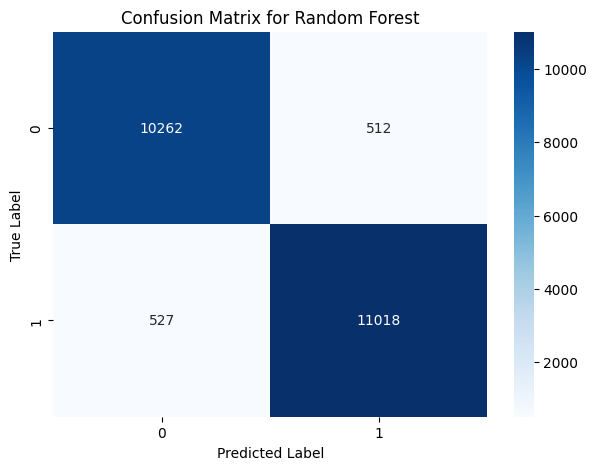

\nNaive Bayes:
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92     10774
         1.0       0.92      0.93      0.93     11545

    accuracy                           0.92     22319
   macro avg       0.92      0.92      0.92     22319
weighted avg       0.92      0.92      0.92     22319



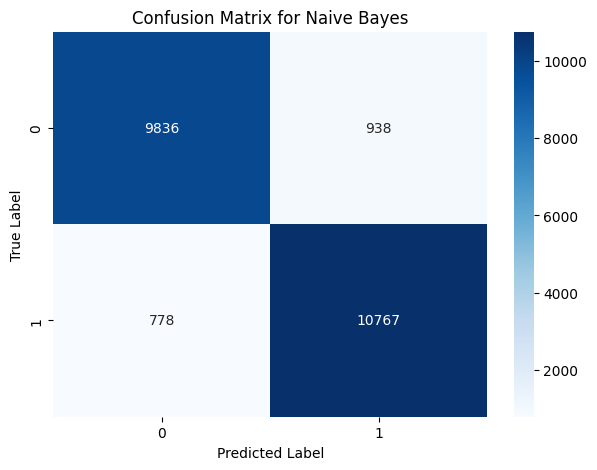

\nLogistic Regression:
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95     10774
         1.0       0.95      0.95      0.95     11545

    accuracy                           0.95     22319
   macro avg       0.95      0.95      0.95     22319
weighted avg       0.95      0.95      0.95     22319



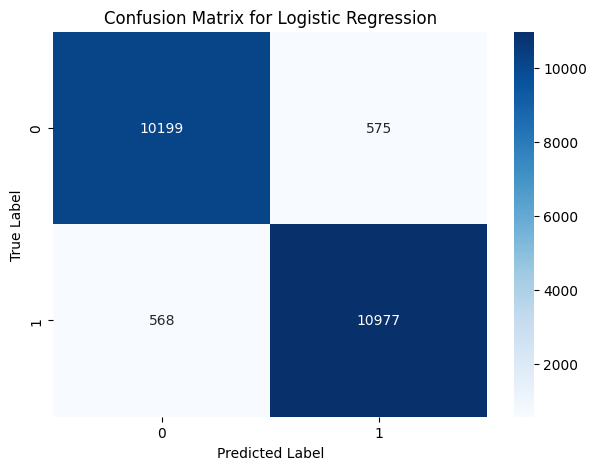

\nGradient Boosting Classifier:
              precision    recall  f1-score   support

         0.0       0.92      0.74      0.82     10774
         1.0       0.79      0.94      0.86     11545

    accuracy                           0.84     22319
   macro avg       0.85      0.84      0.84     22319
weighted avg       0.85      0.84      0.84     22319



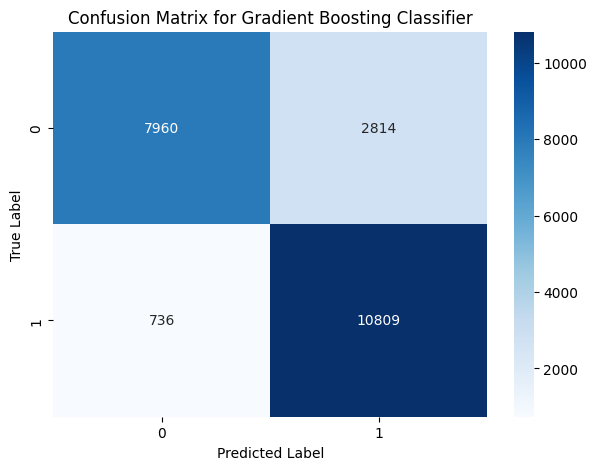

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Vectorize the tweets using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', use_idf=True)
X = vectorizer.fit_transform(df['processed_tweet'])
y = df['BinaryNumLabel']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_jobs=-1),
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Gradient Boosting Classifier": GradientBoostingClassifier()
}

# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {title}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Train and evaluate the classifiers
for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(f"\\n{name}:")
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, name)

In [8]:
print(X)

  (0, 89329)	0.20872283063305613
  (0, 38610)	0.10677905647145475
  (0, 90808)	0.17324993142613138
  (0, 46622)	0.17594836161666771
  (0, 110468)	0.24486159217127024
  (0, 3341)	0.2599435857921464
  (0, 99166)	0.18793130630092741
  (0, 46860)	0.240020307250474
  (0, 105397)	0.1393362262906766
  (0, 5630)	0.18545712002487452
  (0, 56499)	0.15917742269001764
  (0, 69588)	0.13864648486434283
  (0, 20737)	0.16444357350517255
  (0, 32588)	0.1506575603273225
  (0, 19927)	0.12580195609360048
  (0, 129908)	0.16110745391802284
  (0, 12024)	0.2543325788065363
  (0, 6812)	0.15373420061688634
  (0, 9273)	0.10435897547387508
  (0, 5180)	0.250786846042217
  (0, 74858)	0.13915384088996866
  (0, 31871)	0.09950135401793453
  (0, 89298)	0.23129735745880844
  (0, 37016)	0.1894246705802489
  (0, 63585)	0.14225249813559449
  :	:
  (111592, 100007)	0.21259208202782934
  (111592, 85401)	0.22070463397960036
  (111592, 55726)	0.22964370362845918
  (111592, 122976)	0.18056871258424825
  (111592, 108327)	0.15447

We start the study again using BERT models. They are pre trained transformer models (unsupervised Ml algorithms)

In [13]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
import torch

In [14]:
# If running BERT without running Classical ML algorithms first
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [15]:
# Define the TweetDataset class
class TweetDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids = encoding['input_ids'].view(-1)
        attention_mask = encoding['attention_mask'].view(-1)

        return {
            'tweet_text': tweet,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load pre-trained model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/daniel.diaz/Documents/GitHub/CM3070_FP_Repo/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
# Specify the device
device = torch.device("mps")

# Move the model to the device
model = model.to(device)

In [17]:
# Preprocess the tweets
def preprocess(tweet):
    return tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=256, # from 512 -> 256
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

# Apply preprocessing to the entire dataset
X = [preprocess(tweet) for tweet in df['tweet']]
y = df['BinaryNumLabel'].tolist()

# Split the data into training+validation and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training+validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Create the TweetDataset
train_dataset = TweetDataset(
    tweets=X_train,
    labels=y_train,
    tokenizer=tokenizer,
    max_len=256 # from 512 -> 256
)

val_dataset = TweetDataset(
    tweets=X_val,
    labels=y_val,
    tokenizer=tokenizer,
    max_len=256 # from 512 -> 256
)

test_dataset = TweetDataset(
    tweets=X_test,
    labels=y_test,
    tokenizer=tokenizer,
    max_len=256 # from 512 -> 256
)

# Create DataLoaders for training, validation, and testing sets
train_data = DataLoader(train_dataset, batch_size=32) # from 16 -> 32
val_data = DataLoader(val_dataset, batch_size=32) # from 16 -> 32
test_data = DataLoader(test_dataset, batch_size=32) # from 16 -> 32

# Specify the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

epochs = 10 # or any other number depending on how it goes

# to check: early stopping
# set a relatively high number of epochs (e.g., 100 or 1000), and then 
# stop the training early if the model’s performance on a validation set 
# stops improving after a certain number of epochs

# Define the early stopping criteria
patience = 3  # number of epochs to wait for improvement before stopping
best_loss = None
no_improve_count = 0

# Initialize a list to hold the validation losses
val_losses = []

/Users/daniel.diaz/Documents/GitHub/CM3070_FP_Repo/.venv/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


/var/folders/y3/skqrkws14bs48tkyfrn2wnp80000gn/T/ipykernel_52271/3454705677.py:34: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'labels': torch.tensor(label, dtype=torch.long)


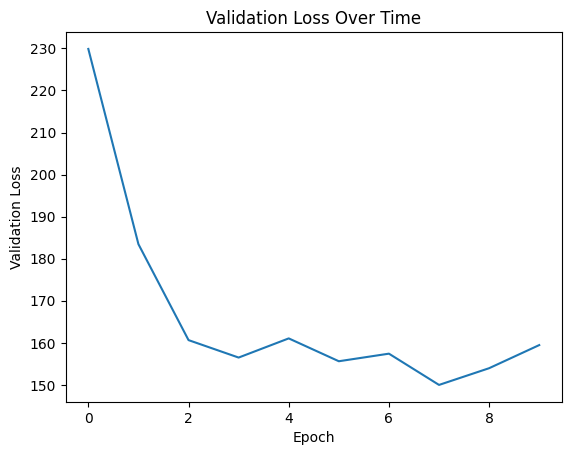

In [18]:
# Initialize a variable to hold the best model path
best_model_path = None

# Train the model
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    for batch in train_data:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].squeeze().to(device)
        attention_mask = batch['attention_mask'].squeeze().to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluate the model on the validation set
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():  # Disable gradient calculation
        for batch in val_data:  # use val_data instead of test_data
            input_ids = batch['input_ids'].squeeze().to(device)
            attention_mask = batch['attention_mask'].squeeze().to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

    # Add the validation loss for this epoch to the list
    val_losses.append(val_loss)

    # Check for improvement
    if best_loss is None or val_loss < best_loss:
        best_loss = val_loss
        no_improve_count = 0
        # Save the model
        model_name = '_bert-base-uncased_'
        dataset_name = '_TruthSeeker2023_'
        model_path = f"_model_epoch{epoch}_valLoss{val_loss:.2f}_batchSize{train_data.batch_size}.pth"
        torch.save(model.state_dict(), dataset_name + model_name + model_path)
        best_model_path = dataset_name + model_name + model_path  # Update the best model path
    else:
        no_improve_count += 1

    # Stop training if there's no improvement for 'patience' epochs
    if no_improve_count >= patience:
        print(f"Stopping training after {epoch} epochs due to no improvement.")
        break

# Plot the validation loss over each epoch
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Time')
plt.show()

In [19]:
# Model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Model evaluation
model.eval()  # Set the model to evaluation mode
y_pred = []
with torch.no_grad():  # Disable gradient calculation
    for batch in test_data:
        input_ids = batch['input_ids'].squeeze().to(device)
        attention_mask = batch['attention_mask'].squeeze().to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        y_pred.extend(torch.argmax(outputs.logits, dim=1).tolist())

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


/var/folders/y3/skqrkws14bs48tkyfrn2wnp80000gn/T/ipykernel_52271/3454705677.py:34: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'labels': torch.tensor(label, dtype=torch.long)


Accuracy: 0.9380796630673417
Precision: 0.9380819341747666
Recall: 0.9380796630673417
F1 Score: 0.9380806101190583


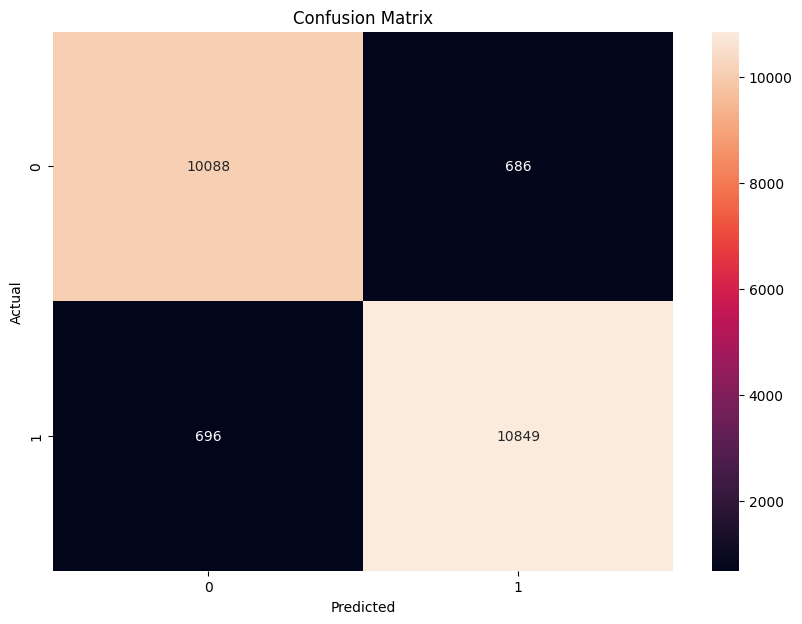

In [20]:
# Import the necessary libraries
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [21]:
# Save the best model
torch.save(model.state_dict(), best_model_path)

In [67]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
import torch

In [68]:
# Define the TweetDataset class
class TweetDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids = encoding['input_ids'].view(-1)
        attention_mask = encoding['attention_mask'].view(-1)

        return {
            'tweet_text': tweet,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load pre-trained model and tokenizer
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/daniel.diaz/Documents/GitHub/CM3070_FP_Repo/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [69]:
# Specify the device
device = torch.device("mps")

# Move the model to the device
model = model.to(device)

In [70]:
# Preprocess the tweets
def preprocess(tweet):
    return tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=256,  # Changed from 512 to 256
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
    )

# Apply preprocessing to the entire dataset
X = [preprocess(tweet) for tweet in df['tweet']]
y = df['BinaryNumLabel'].tolist()

# Split the data into training+validation and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training+validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Create the TweetDataset
train_dataset = TweetDataset(
    tweets=X_train,
    labels=y_train,
    tokenizer=tokenizer,
    max_len=256  # Changed from 512 to 256
)

val_dataset = TweetDataset(
    tweets=X_val,
    labels=y_val,
    tokenizer=tokenizer,
    max_len=256  # Changed from 512 to 256
)

test_dataset = TweetDataset(
    tweets=X_test,
    labels=y_test,
    tokenizer=tokenizer,
    max_len=256  # Changed from 512 to 256
)

# Create DataLoaders for training, validation, and testing sets
train_data = DataLoader(train_dataset, batch_size=32)  # Changed from 16 to 32
val_data = DataLoader(val_dataset, batch_size=32)  # Changed from 16 to 32
test_data = DataLoader(test_dataset, batch_size=32)  # Changed from 16 to 32

# Specify the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5) #, weight_decay=0.01)  # Added weight_decay

epochs = 10  # Changed from 10 to 2

/Users/daniel.diaz/Documents/GitHub/CM3070_FP_Repo/.venv/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [71]:

# to check: early stopping
# set a relatively high number of epochs (e.g., 100 or 1000), and then 
# stop the training early if the model’s performance on a validation set 
# stops improving after a certain number of epochs

# Define the early stopping criter
patience = 3  # number of epochs to wait for improvement before stopping
best_loss = None
no_improve_count = 0

# Initialize a list to hold the validation losses
val_losses = []


/var/folders/y3/skqrkws14bs48tkyfrn2wnp80000gn/T/ipykernel_52271/2356349814.py:34: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'labels': torch.tensor(label, dtype=torch.long)


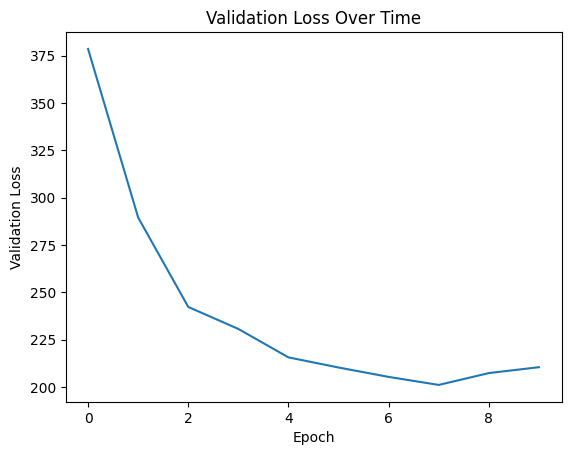

In [72]:
# Initialize a variable to hold the best model path
best_model_path = None

# Train the model
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    for batch in train_data:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].squeeze().to(device)
        attention_mask = batch['attention_mask'].squeeze().to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluate the model on the validation set
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():  # Disable gradient calculation
        for batch in val_data:
            input_ids = batch['input_ids'].squeeze().to(device)
            attention_mask = batch['attention_mask'].squeeze().to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

    # Add the validation loss for this epoch to the list
    val_losses.append(val_loss)

    # Check for improvement
    if best_loss is None or val_loss < best_loss:
        best_loss = val_loss
        no_improve_count = 0
        # Save the model
        model_name = '_roberta-base_'
        dataset_name = '_TruthSeeker2023_'
        model_path = f"_model_epoch{epoch}_valLoss{val_loss:.2f}_batchSize{train_data.batch_size}.pth"
        torch.save(model.state_dict(), dataset_name + model_name + model_path)
        best_model_path = dataset_name + model_name + model_path  # Update the best model path
    else:
        no_improve_count += 1

    # Stop training if there's no improvement for 'patience' epochs
    if no_improve_count >= patience:
        print(f"Stopping training after {epoch} epochs due to no improvement.")
        break

# Plot the validation loss over each epoch
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Time')
plt.show()

In [73]:

# Model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Model evaluation
model.eval()  # Set the model to evaluation mode
y_pred = []
with torch.no_grad():  # Disable gradient calculation
    for batch in test_data:
        input_ids = batch['input_ids'].squeeze().to(device)
        attention_mask = batch['attention_mask'].squeeze().to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        y_pred.extend(torch.argmax(outputs.logits, dim=1).tolist())

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

/var/folders/y3/skqrkws14bs48tkyfrn2wnp80000gn/T/ipykernel_52271/2356349814.py:34: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'labels': torch.tensor(label, dtype=torch.long)


Accuracy: 0.899995519512523
Precision: 0.9002702892859362
Recall: 0.899995519512523
F1 Score: 0.8999183246235541


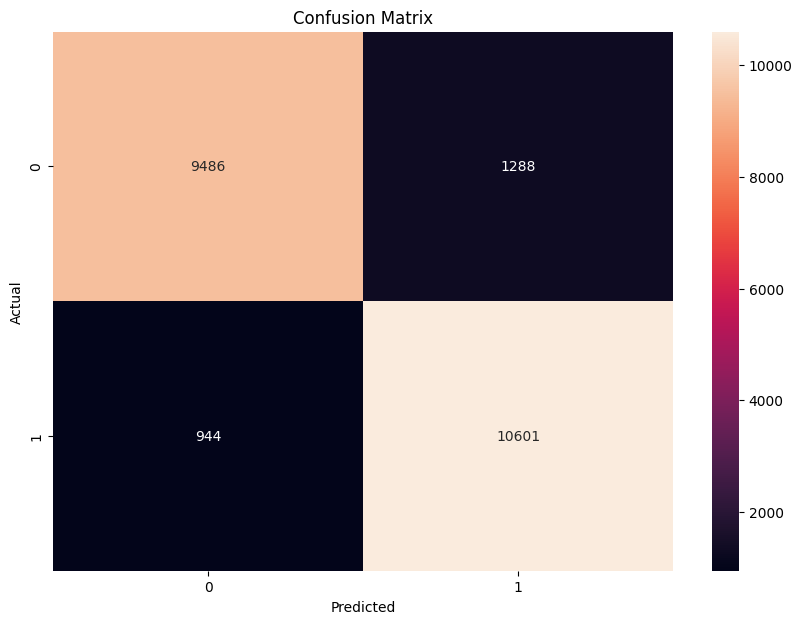

In [74]:
# Import the necessary libraries
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [75]:
# Save the best model
torch.save(model.state_dict(), best_model_path)

In [76]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
import torch


In [77]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [78]:

# Define the TweetDataset class
class TweetDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids = encoding['input_ids'].view(-1)
        attention_mask = encoding['attention_mask'].view(-1)

        return {
            'tweet_text': tweet,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load pre-trained model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/daniel.diaz/Documents/GitHub/CM3070_FP_Repo/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [79]:

# Specify the device
device = torch.device("mps")

# Move the model to the device
model = model.to(device)


In [80]:

# Preprocess the tweets
def preprocess(tweet):
    return tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=256,  # Token length size set to 256
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

# Apply preprocessing to the entire dataset
X = [preprocess(tweet) for tweet in df['tweet']]
y = df['BinaryNumLabel'].tolist()

# Split the data into training+validation and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training+validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Create the TweetDataset
train_dataset = TweetDataset(
    tweets=X_train,
    labels=y_train,
    tokenizer=tokenizer,
    max_len=256  # Token length size set to 256
)

val_dataset = TweetDataset(
    tweets=X_val,
    labels=y_val,
    tokenizer=tokenizer,
    max_len=256  # Token length size set to 256
)

test_dataset = TweetDataset(
    tweets=X_test,
    labels=y_test,
    tokenizer=tokenizer,
    max_len=256  # Token length size set to 256
)

# Create DataLoaders for training, validation, and testing sets
train_data = DataLoader(train_dataset, batch_size=32)  # Batch size set to 32
val_data = DataLoader(val_dataset, batch_size=32)  # Batch size set to 32
test_data = DataLoader(test_dataset, batch_size=32)  # Batch size set to 32

# Specify the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

epochs = 10  # or any other number depending on how it goes


/Users/daniel.diaz/Documents/GitHub/CM3070_FP_Repo/.venv/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [81]:

# Define the early stopping criteria
patience = 3  # number of epochs to wait for improvement before stopping
best_loss = None
no_improve_count = 0

# Initialize a list to hold the validation losses
val_losses = []


In [82]:
# Initialize a variable to hold the best model path
best_model_path = None

# Train the model
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    for batch in train_data:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].squeeze().to(device)
        attention_mask = batch['attention_mask'].squeeze().to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluate the model on the validation set
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():  # Disable gradient calculation
        for batch in val_data:
            input_ids = batch['input_ids'].squeeze().to(device)
            attention_mask = batch['attention_mask'].squeeze().to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

    # Add the validation loss for this epoch to the list
    val_losses.append(val_loss)

    # Check for improvement
    if best_loss is None or val_loss < best_loss:
        best_loss = val_loss
        no_improve_count = 0
        # Save the model
        model_name = '_distilbert-base-uncased_'
        dataset_name = '_TruthSeeker2023_'
        model_path = f"_model_epoch{epoch}_valLoss{val_loss:.2f}_batchSize{train_data.batch_size}.pth"
        torch.save(model.state_dict(), dataset_name + model_name + model_path)
        best_model_path = dataset_name + model_name + model_path  # Update the best model path
    else:
        no_improve_count += 1

    # Stop training if there's no improvement for 'patience' epochs
    if no_improve_count >= patience:
        print(f"Stopping training after {epoch} epochs due to no improvement.")
        break

# Plot the validation loss over each epoch
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Time')
plt.show()


/var/folders/y3/skqrkws14bs48tkyfrn2wnp80000gn/T/ipykernel_52271/604678406.py:34: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'labels': torch.tensor(label, dtype=torch.long)


In [ ]:

# Model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Model evaluation
model.eval()  # Set the model to evaluation mode
y_pred = []
with torch.no_grad():  # Disable gradient calculation
    for batch in test_data:
        input_ids = batch['input_ids'].squeeze().to(device)
        attention_mask = batch['attention_mask'].squeeze().to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        y_pred.extend(torch.argmax(outputs.logits, dim=1).tolist())

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


/var/folders/y3/skqrkws14bs48tkyfrn2wnp80000gn/T/ipykernel_29795/604678406.py:34: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'labels': torch.tensor(label, dtype=torch.long)


Accuracy: 0.9262511761279627
Precision: 0.9262486476650363
Recall: 0.9262511761279627
F1 Score: 0.9262495470536097


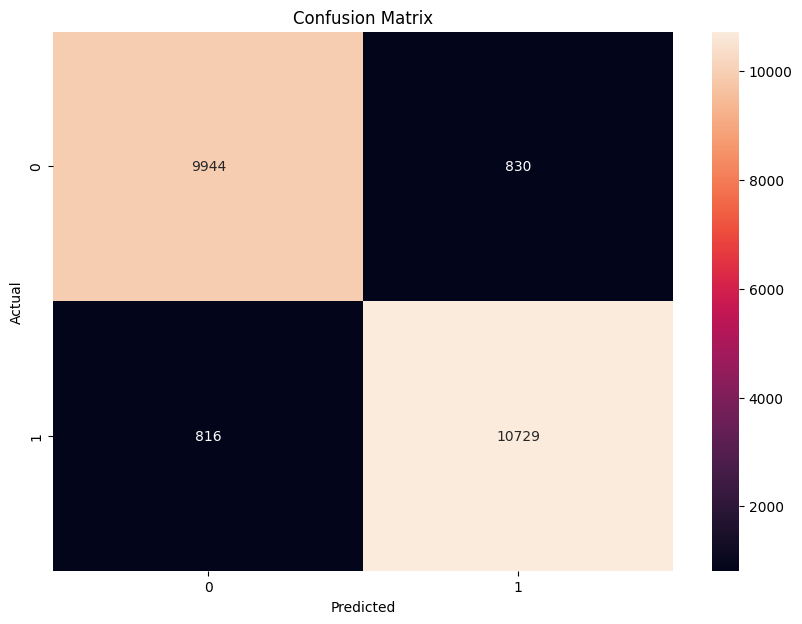

In [ ]:

# Plot the confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# Save the best model
torch.save(model.state_dict(), best_model_path)

In [56]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
import torch


In [57]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [58]:

# Define the TweetDataset class
class TweetDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids = encoding['input_ids'].view(-1)
        attention_mask = encoding['attention_mask'].view(-1)

        return {
            'tweet_text': tweet,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load pre-trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained('vinai/bertweet-base')
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', use_fast=False)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:

# Specify the device
device = torch.device("mps")

# Move the model to the device
model = model.to(device)


In [60]:

# Preprocess the tweets
def preprocess(tweet):
    return tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=130,  # Token length size set to 130 by design
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

# Apply preprocessing to the entire dataset
X = [preprocess(tweet) for tweet in df['tweet']]
y = df['BinaryNumLabel'].tolist()

# Split the data into training+validation and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training+validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Create the TweetDataset
train_dataset = TweetDataset(
    tweets=X_train,
    labels=y_train,
    tokenizer=tokenizer,
    max_len=130  #  # Token length size set to 130 by design
)

val_dataset = TweetDataset(
    tweets=X_val,
    labels=y_val,
    tokenizer=tokenizer,
    max_len=130  #  # Token length size set to 130 by design
)

test_dataset = TweetDataset(
    tweets=X_test,
    labels=y_test,
    tokenizer=tokenizer,
    max_len=130  #  # Token length size set to 130 by design
)

# Create DataLoaders for training, validation, and testing sets
train_data = DataLoader(train_dataset, batch_size=32)  # Batch size set to 32
val_data = DataLoader(val_dataset, batch_size=32)  # Batch size set to 32
test_data = DataLoader(test_dataset, batch_size=32)  # Batch size set to 32

# Specify the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

epochs = 10  # or any other number depending on how it goes


In [61]:

# Define the early stopping criteria
patience = 3  # number of epochs to wait for improvement before stopping
best_loss = None
no_improve_count = 0

# Initialize a list to hold the validation losses
val_losses = []


/var/folders/y3/skqrkws14bs48tkyfrn2wnp80000gn/T/ipykernel_52271/3364642507.py:34: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'labels': torch.tensor(label, dtype=torch.long)


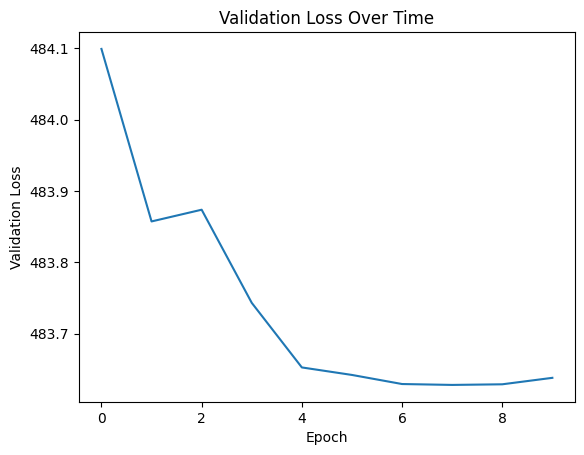

In [62]:
# Initialize a variable to hold the best model path
best_model_path = None

# Train the model
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    for batch in train_data:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].squeeze().to(device)
        attention_mask = batch['attention_mask'].squeeze().to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluate the model on the validation set
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():  # Disable gradient calculation
        for batch in val_data:
            input_ids = batch['input_ids'].squeeze().to(device)
            attention_mask = batch['attention_mask'].squeeze().to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

    # Add the validation loss for this epoch to the list
    val_losses.append(val_loss)

    # Check for improvement
    if best_loss is None or val_loss < best_loss:
        best_loss = val_loss
        no_improve_count = 0
        # Save the model
        model_name = '_bertweet-base_'
        dataset_name = '_TruthSeeker2023_'
        model_path = f"_model_epoch{epoch}_valLoss{val_loss:.2f}_batchSize{train_data.batch_size}.pth"
        torch.save(model.state_dict(), dataset_name + model_name + model_path)
        best_model_path = dataset_name + model_name + model_path  # Update the best model path
    else:
        no_improve_count += 1

    # Stop training if there's no improvement for 'patience' epochs
    if no_improve_count >= patience:
        print(f"Stopping training after {epoch} epochs due to no improvement.")
        break

# Plot the validation loss over each epoch
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Time')
plt.show()


In [63]:

# Model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Model evaluation
model.eval()  # Set the model to evaluation mode
y_pred = []
with torch.no_grad():  # Disable gradient calculation
    for batch in test_data:
        input_ids = batch['input_ids'].squeeze().to(device)
        attention_mask = batch['attention_mask'].squeeze().to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        y_pred.extend(torch.argmax(outputs.logits, dim=1).tolist())

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


/var/folders/y3/skqrkws14bs48tkyfrn2wnp80000gn/T/ipykernel_52271/3364642507.py:34: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'labels': torch.tensor(label, dtype=torch.long)


Accuracy: 0.5172722792239796
Precision: 0.2675706108535707
Recall: 0.5172722792239796
F1 Score: 0.35269953128046555


/Users/daniel.diaz/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


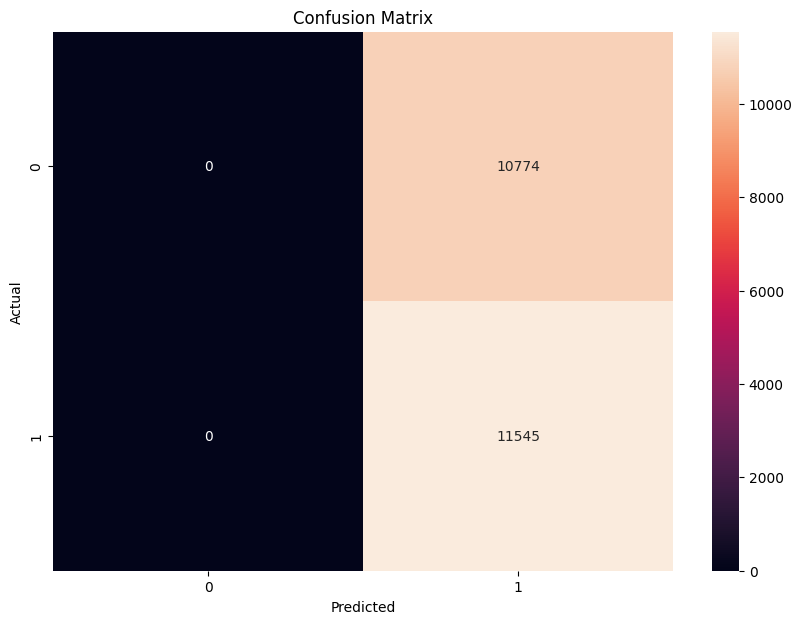

In [64]:

# Plot the confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [65]:

# Save the best model
torch.save(model.state_dict(), best_model_path)